In [1]:
import numpy as np
import NNAccelerator
import time
import heapq
from PIL import Image
from IPython.display import display

In [2]:
def load_image(infilename):
    img = Image.open(infilename)
    img.load()
    img = img.convert('RGB')
    data = np.asarray(img,dtype=np.uint8)
    return  data

In [17]:
VGG16Version = 'VGG_16'
cnnName = 'VGG16'

bitFileName = 'cnna6.16.8.3.800' #166, 169, 170
#bitFileName = 'cnna4.8.16.1.798' #167
#bitFileName = 'cnna4.8.8.3.546' #168
    
dataset = '_detect'

bitFile = 'bitFiles/180MHz/170/170.bit'
#bitFile = 'bitFiles/' + bitFileName + '/' + bitFileName + '.bit'
cnnSpec = 'cnnSpecs/' + cnnName + '/' + cnnName+ dataset + '.json'
cnnWeights = 'cnnSpecs/' + cnnName + '/' + cnnName + dataset + '_pre_'+ bitFileName+ '.h5'
beforeAccLoad = time.time()
acc = NNAccelerator.NNAccelerator(bitfile = bitFile, NNJsonSpec = cnnSpec, H5Weights = cnnWeights, preConverted = True, preAlligned = True,verboseLevel = 4,dmaSafe = True)
afterAccLoad = time.time()
print('Loading time: ',afterAccLoad-beforeAccLoad)
acc.verboseLevel = 4

dataW:  16 , dataP:  2 , dmaBW:  8 , PE_N:  8 , peBwN:  8 , dataOut:  3 , wbufSize:  800
DMA MULT:  4
input_1 , kernelSize:  0 , nFilters:  0, filtersPrSplit:  0 , nSplits:  1 , outputSize:  [224, 224, 3]
, paddingSize:  1.0block1_conv1 , kernelSize:  [3, 3] , nFilters:  64, filtersPrSplit:  64 , nSplits:  1.0 , outputSize:  (224.0, 224.0, 64)
, paddingSize:  1.0block1_conv2 , kernelSize:  [3, 3] , nFilters:  64, filtersPrSplit:  64 , nSplits:  1.0 , outputSize:  (224.0, 224.0, 64)
, paddingSize:  0block1_pool , kernelSize:  [2, 2] , nFilters:  0, filtersPrSplit:  0 , nSplits:  1 , outputSize:  (112.0, 112.0, 64)
, paddingSize:  1.0block2_conv1 , kernelSize:  [3, 3] , nFilters:  128, filtersPrSplit:  128 , nSplits:  1.0 , outputSize:  (112.0, 112.0, 128)
, paddingSize:  1.0block2_conv2 , kernelSize:  [3, 3] , nFilters:  128, filtersPrSplit:  128.0 , nSplits:  1.0 , outputSize:  (112.0, 112.0, 128)
, paddingSize:  0block2_pool , kernelSize:  [2, 2] , nFilters:  0, filtersPrSplit:  0 , n

loading weights for  dense_1, time taken:  1.8660507202148438
loading weights for  dense_2, time taken:  1.150017499923706
loading weights for  dense_3, time taken:  0.004987001419067383
loading weights for  flatten_1, time taken:  0.0006325244903564453
loading weights for  input_1, time taken:  0.0004150867462158203
parameters
depth:  64 , rowSize:  224.0 , stride:  2 , window:  2 , zeroPad: 0 , depthRaw:  8.0 , rowSizeY:  112.0 , imageSize:  401408.0
depth:  128 , rowSize:  112.0 , stride:  2 , window:  2 , zeroPad: 0 , depthRaw:  16.0 , rowSizeY:  56.0 , imageSize:  200704.0
depth:  256 , rowSize:  56.0 , stride:  2 , window:  2 , zeroPad: 0 , depthRaw:  32.0 , rowSizeY:  28.0 , imageSize:  100352.0
depth:  512 , rowSize:  28.0 , stride:  2 , window:  2 , zeroPad: 0 , depthRaw:  64.0 , rowSizeY:  14.0 , imageSize:  50176.0
depth:  512 , rowSize:  14.0 , stride:  2 , window:  2 , zeroPad: 0 , depthRaw:  64.0 , rowSizeY:  7.0 , imageSize:  12544.0
splits:  512.0  splits:  512.0  split

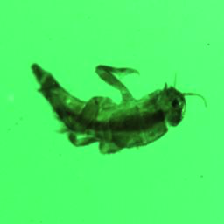

In [4]:
imageFile = 'detect/detect1_3.jpg'
img = load_image(imageFile)
convertedX = np.expand_dims(img,axis=0)
display(Image.fromarray(img))

In [15]:
acc.verboseLevel = 0.2
t = acc.predict(convertedX)

layer = 'dense_3'
outputs2 = acc.variableExtract(acc.outputs[layer][acc.layers[layer].finalOutIdx],5)
classes = heapq.nlargest(5,range(len(outputs2)),outputs2.__getitem__)
print('Result')
for i in range(5):
    print('    ', classes[i]+1 , outputs2[classes[i]])

print(t, acc.softmax(outputs2), np.sum(acc.softmax(outputs2)))

starting prediction
time taken:  1.933065414428711
Result
     3 1.99994
     1 -1.38977
     2 -1.40302
     5 -1.68127
     4 -2.0
(1.933065414428711, 2) [ 0.03036326  0.02996376  0.90049332  0.01649412  0.02268558] 1.0


In [7]:
acc.verboseLevel = 0.2
predictedClasses = list()
for i in range(5):
    for j in range(3):
        imageFile = 'detect/detect' + str(i+1) + '_' + str(j+1) + '.jpg'
        img = load_image(imageFile)
        convertedX = np.expand_dims(img,axis=0)
        #acc.outputs[layer][acc.layers[layer].finalOutIdx].invalidate()
        acc.predict(convertedX)
        layer = 'dense_3'
        outputs2 = acc.variableExtract(acc.outputs[layer][acc.layers[layer].finalOutIdx],5)
        classes = heapq.nlargest(5, range(len(outputs2)),outputs2.__getitem__)
        predictedClasses.append((i,classes))
        #time.sleep(0.5)
        
correct = 0
wrong = 0
for predicted in range(len(predictedClasses)):
    if predictedClasses[predicted][0] == predictedClasses[predicted][1][0]:
        correct += 1
    else:
        wrong += 1

print('correctness = ', correct/len(predictedClasses))

starting prediction
time taken:  1.9328076839447021
starting prediction
time taken:  1.9652798175811768
starting prediction
time taken:  1.9241433143615723
starting prediction
time taken:  1.9540319442749023
starting prediction
time taken:  1.922513723373413
starting prediction
time taken:  1.952293872833252
starting prediction
time taken:  1.9219658374786377
starting prediction
time taken:  1.9533209800720215
starting prediction
time taken:  1.9256877899169922
starting prediction
time taken:  1.9560976028442383
starting prediction
time taken:  1.9232730865478516
starting prediction
time taken:  1.9557075500488281
starting prediction
time taken:  1.9249532222747803
starting prediction
time taken:  1.9547688961029053
starting prediction
time taken:  1.9232914447784424
correctness =  0.6666666666666666


In [13]:
for predicted in range(len(predictedClasses)):
    print(predictedClasses[predicted])

(0, [0, 1, 2, 3, 4])
(0, [0, 1, 2, 3, 4])
(0, [0, 1, 2, 3, 4])
(1, [1, 0, 4, 2, 3])
(1, [1, 0, 2, 3, 4])
(1, [1, 3, 4, 0, 2])
(2, [2, 0, 1, 4, 3])
(2, [1, 0, 4, 2, 3])
(2, [1, 2, 0, 4, 3])
(3, [1, 0, 4, 2, 3])
(3, [3, 4, 1, 0, 2])
(3, [4, 0, 1, 2, 3])
(4, [0, 4, 1, 2, 3])
(4, [4, 3, 0, 1, 2])
(4, [4, 0, 3, 1, 2])


class:  1


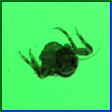

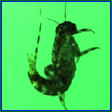

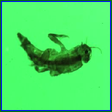

class:  2


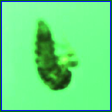

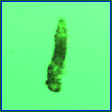

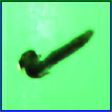

class:  3


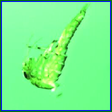

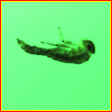

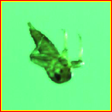

class:  4


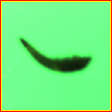

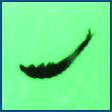

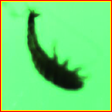

class:  5


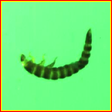

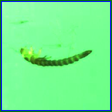

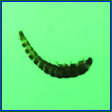

In [14]:
from PIL import ImageOps

for i in range(5):
    print('class: ' , i+1)
    for j in range(3):
        imageFile = 'detect/detect' + str(i+1) + '_' + str(j+1) + '.jpg'
        img = Image.open(imageFile)
        img.load()
        img = img.convert('RGB')
        if predictedClasses[j+i*3][0] == predictedClasses[j+i*3][1][0]:   
            fillA = 'blue'
            fillB = 'green'
        else:
            fillA = 'yellow'
            fillB = 'red'
        scale = int(224*0.5)
        img = ImageOps.expand(ImageOps.expand(img,border=2,fill=fillA),border=2,fill=fillB).resize((scale,scale),Image.ANTIALIAS)
        display(img)


In [10]:
acc.verboseLevel = 0
mode = 'complete'
imageFile = 'detect/detect3_1.jpg'
img = load_image(imageFile)
convertedX = np.expand_dims(img,axis=0)

nSamples = 30
samples = np.zeros(shape=(nSamples,))

for i in range(nSamples):
    t = acc.predict(convertedX)#,imageData=True)
    samples[i] = t[0]
    
print('mean: ',np.mean(samples), ', variance: ',np.var(samples))
import pickle
with open('vgg16times_'+mode+'_'+bitFileName+'.pkl','wb') as f:
    pickle.dump(samples,f)

mean:  1.93798767726 , variance:  0.000291032654831


In [29]:
outputs = dict()
for layer in acc.layers:#layerList:
    #print(acc.outputs[layer])
    if 'input' not in layer:
        if 'conv' in layer or 'pool' in layer:
            nOutVars = acc.layers[layer].outputSize[0]* acc.layers[layer].outputSize[1]* acc.layers[layer].outputSize[2]
        else:
            nOutVars = acc.layers[layer].outputSize

        print(layer,nOutVars)
        out = acc.variableExtract(acc.outputs[layer][acc.layers[layer].finalOutIdx],int(nOutVars))
        outputs.update({layer:out})

block1_conv1 3211264.0
block1_conv2 3211264.0
block1_pool 802816.0
block2_conv1 1605632.0
block2_conv2 1605632.0
block2_pool 401408.0
block3_conv1 802816.0
block3_conv2 802816.0
block3_conv3 802816.0
block3_pool 200704.0
block4_conv1 401408.0
block4_conv2 401408.0
block4_conv3 401408.0
block4_pool 100352.0
block5_conv1 100352.0
block5_conv2 100352.0
block5_conv3 100352.0
block5_pool 25088.0
flatten_1 25088.0
dense_1 4096
dense_2 4096
dense_3 5


In [30]:
import pickle
with open('vgg16outputs'+bitFileName+'.pkl','wb') as f:
    pickle.dump(outputs,f)

In [4]:
#pool 512
acc.verboseLevel = 0
mode = 'complete'
imageSize = 28
depth = 512
stride = 2
window = 2
dmaX = acc.xlnk.cma_array(shape=(int(imageSize*imageSize*depth/(acc.DMA_MULT))),dtype=np.uint64)
dmaY = acc.xlnk.cma_array(shape=(int((imageSize/stride*imageSize/stride*depth)/(acc.DMA_MULT))),dtype=np.uint64)

parameterBuffer = acc.allocParameterBufferPool()
acc.parameterCalcPool(parameterBuffer,depth, imageSize, stride, window, 0)

parameterBuffer = acc.convertNpToCma(parameterBuffer)

samples = np.zeros(shape = (30,))
for i in range(30):
    before = time.time()
    acc.doPool(parameterBuffer,dmaX,dmaY) #depth = 512, image_size = 28, stride = 2, window = 2, zeropad = 0
    after = time.time()
    samples[i] = after-before
    #print('pool 512 - time taken: ',after-before)

print('mean: ',np.mean(samples), ', variance: ',np.var(samples))
import pickle
with open('vgg16times_pool512_'+mode+'_'+bitFileName+'.pkl','wb') as f:
    pickle.dump(samples,f)

mean:  0.0024134238561 , variance:  1.759654285e-09


In [5]:
#conv test
acc.verboseLevel = 0
mode = 'complete'
imageData = False
imageSize = 16
depth = 64
nW = 64
wSize = 3
stride = 1
padding = 1
xn = 1
dmaX = acc.xlnk.cma_array(shape = (int(xn*imageSize*imageSize*64/acc.DMA_MULT)), dtype=np.uint64)
dmaYConv = acc.allocDmaYArray(imageSize, wSize, nW, stride,padding)
dmaW = acc.allocateDmaWArray(wSize, depth, nW)
dmaWUse = acc.convertNpToCma(dmaW[0])

parameterBuffer = acc.allocParameterBufferConv()
acc.parameterCalcConv(parameterBuffer, wSize, dmaW[2], imageSize, stride, xn, nW, True, padding, imageData = imageData)

parameterBuffer = acc.convertNpToCma(parameterBuffer)

samples = np.zeros(shape = (30,))
for i in range(30):
    before = time.time()
    acc.doConv(parameterBuffer,dmaX,dmaWUse,dmaYConv)
    after = time.time()
    samples[i] = after-before
    #print('conv - time taken: ',after-before)

print('mean: ',np.mean(samples), ', variance: ',np.var(samples))
import pickle
with open('vgg16times_conv_'+mode+'_'+bitFileName+'.pkl','wb') as f:
    pickle.dump(samples,f)

mean:  0.00096005598704 , variance:  5.50094822276e-08


In [6]:
#image conv test
acc.verboseLevel = 0
mode = 'complete'
imageData = True
imageSize = 32
depth = 3
nW = 64
wSize = 3
stride = 1
padding = 1
dmaX = acc.xlnk.cma_array(shape = (imageSize,imageSize,3), dtype=np.uint8)
dmaY = acc.allocDmaYArray(imageSize, wSize, nW, stride,padding)
dmaW = acc.allocateDmaWArray(wSize, depth, nW)
dmaWUse = acc.convertNpToCma(dmaW[0])

parameterBuffer = acc.allocParameterBufferConv()
acc.parameterCalcConv(parameterBuffer, wSize, dmaW[2], imageSize, stride, xn, nW, True, padding, imageData = imageData)

parameterBuffer = acc.convertNpToCma(parameterBuffer)


samples = np.zeros(shape = (30,))
for i in range(30):
    before = time.time()
    acc.doConv(parameterBuffer, dmaX, dmaWUse, dmaY)
    after = time.time()
    samples[i] = after-before
    #print('image conv - time taken: ',after-before)

print('mean: ',np.mean(samples), ', variance: ',np.var(samples))
import pickle
with open('vgg16times_imageconv_'+mode+'_'+bitFileName+'.pkl','wb') as f:
    pickle.dump(samples,f)

mean:  0.000757233301799 , variance:  1.1295495723e-08


In [7]:
#pool 1
acc.verboseLevel = 0
mode = 'complete'
imageSize = 32
depth = 64
stride = 2
window = 2
dmaXpool1 = acc.xlnk.cma_array(shape=(int(imageSize*imageSize*depth/(acc.DMA_MULT))),dtype=np.uint64)
dmaYpool1 = acc.xlnk.cma_array(shape=(int((imageSize/stride*imageSize/stride*depth)/(acc.DMA_MULT))),dtype=np.uint64)

parameterBuffer = acc.allocParameterBufferPool()
acc.parameterCalcPool(parameterBuffer,depth, imageSize, stride, window, 0)

parameterBuffer = acc.convertNpToCma(parameterBuffer)

samples = np.zeros(shape = (30,))
for i in range(30):
    before = time.time()
    acc.doPool(parameterBuffer, dmaXpool1,dmaYpool1) 
    after = time.time()
    samples[i] = after-before
    #print('pool 1 - time taken: ',after-before)
print('mean: ',np.mean(samples), ', variance: ',np.var(samples))
import pickle
with open('vgg16times_pool1_'+mode+'_'+bitFileName+'.pkl','wb') as f:
    pickle.dump(samples,f)

mean:  0.000645399093628 , variance:  3.61155040688e-09


In [8]:
#fc test
acc.verboseLevel = 0
mode = 'complete'
imageSize = 16
depth = 64
nOut = 128
nIn = imageSize*imageSize*depth

dmaY = acc.allocateDmaYFCArray(nOut)
weight = acc.allocateDmaWFCArray(nIn,acc.PE_N)
dmaWbuffer = acc.convertNpToCma(weight[0])     
newUnits = weight[1]
nUnitsToLoad = acc.PE_N

DMAbytesAddPrSplit = acc.DATA_WIDTH/8*acc.PE_N

parameterBuffer = acc.allocParameterBufferFC()
acc.parameterCalcFC(parameterBuffer,nIn,nUnitsToLoad,newUnits,True)
parameterBuffer = acc.convertNpToCma(parameterBuffer)
        
samples = np.zeros(shape = (30,))
for j in range(30):
    before = time.time()
    for i in range(int(nOut/acc.PE_N)):

        outDMA = NNAccelerator.DMAidx(int(dmaY.nbytes-(DMAbytesAddPrSplit*i)),
            int(dmaY.physical_address + (DMAbytesAddPrSplit*i)),
            dmaY) 
        acc.doFC(parameterBuffer, dmaYpool1, dmaWbuffer, outDMA)
    after = time.time()
    samples[j] = after-before
    #print('fc - time taken: ',after-before)
print('mean: ',np.mean(samples), ', variance: ',np.var(samples))
import pickle
with open('vgg16times_fc_'+mode+'_'+bitFileName+'.pkl','wb') as f:
    pickle.dump(samples,f)      

mean:  0.00870405832926 , variance:  1.0314853297e-07


In [ ]:
np.random.seed(0)
imageSize = 4
nImages = 1
depth = 64
wSize = 3
nW = 64
stitchBufDepth = 32
one = 2**8

dmaX = acc.xlnk.cma_array(shape=(int(imageSize*imageSize*depth/4)),dtype=np.uint64)
dmaY = acc.xlnk.cma_array(shape=(int(imageSize*imageSize*depth/4)+int(imageSize*imageSize*stitchBufDepth/4)),dtype=np.uint64)
dmaStitchBuf = acc.xlnk.cma_array(shape=(int(imageSize*imageSize*stitchBufDepth/4)),dtype=np.uint64)

for i in range(imageSize):
    for a in range(imageSize):
        for b in range(depth):
            dmaX[i*imageSize+b] = a*2**8
stride = 1
window = 3  
zeroPad = 1
weights = acc.convertNpToCma(acc.weights['block1_conv2'][0][0])
npWeights = np.copy(weights)
dmaIdx = NNAccelerator.DMAidx(npWeights.nbytes,npWeights.ctypes.data, npWeights)

acc.doConv(dmaX, weights, dmaY, window, depth, imageSize, stride, 1, nW, True,zeroPad,0,0,None)

acc.doConv(dmaX,weights , dmaY, window, depth, imageSize, stride, 1, nW, True,zeroPad,depth+stitchBufDepth,stitchBufDepth,dmaStitchBuf)

doing conv: dmaX:  (256,) , dmaW:  (9600,) , dmaY:  (384,) , window 3 , depth:  64 , rowSize:  4 , stride:  1 , xN:  1 , wN:  64 , ReLu:  True , zeroPad:  1 rowSizeY:  4.0 , imageSize:  128.0 , stitchDepth:  0 , stitchBufDepth:  0 , stitchNbytes:  0
sending W data
sending X data
using ReLu
Conv setup done
waiting for result
doing conv: dmaX:  (256,) , dmaW:  (9600,) , dmaY:  (384,) , window 3 , depth:  64 , rowSize:  4 , stride:  1 , xN:  1 , wN:  64 , ReLu:  True , zeroPad:  1 rowSizeY:  4.0 , imageSize:  128.0 , stitchDepth:  96 , stitchBufDepth:  32 , stitchNbytes:  0, stitchBuf:  (128,)
sending W data
sending buf data
sending X data
using ReLu
Conv setup done
waiting for result
